In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, SpectralClustering, KMeans

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#load MNIST data
num_samples = 5000
dim = 28 * 28

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train[:num_samples] / 128 - 1).astype(np.float32)
y_train = y_train[:num_samples]
x_train = x_train.reshape([-1, dim])
x_train.shape

(5000, 784)

In [3]:
#helper to show arrays of images
def imshow(img):
    fig = plt.figure(figsize=(20, 15))
    img = img.reshape([-1, 28, 28])
    out = np.empty([0, 280])
    for row in range((len(img) - 1) // 10 + 1):
        add = np.hstack(img[row * 10: row * 10 + 10])
        add = np.hstack([add, np.zeros([28, 280 - add.shape[1]])])
        out = np.vstack([out, add])
    plt.imshow(out)

In [4]:
#GAN model
tf.reset_default_graph()
sess = tf.InteractiveSession()

z_dim = 10
A = lambda x: tf.nn.leaky_relu(x, 0.01)

X = tf.placeholder(tf.float32, [None, dim])
Z = tf.placeholder(tf.float32, [None, z_dim])

def generator(Z, reuse=False):
    with tf.variable_scope('gen', reuse=reuse):
        L = Z
        L = tf.layers.dense(L, 64, activation=A)
        L = tf.layers.dense(L, 256, activation=A)
        L = tf.layers.dense(L, dim)
        return tf.nn.tanh(L), L

def discriminator(X, reuse=False):
    with tf.variable_scope('dis', reuse=reuse):
        L = X
        L = tf.layers.dense(L, 256, activation=A)
        L = tf.layers.dense(L, 64, activation=A)
        L = tf.layers.dense(L, 1)
        return tf.nn.sigmoid(L), L

GEN_OUT, GEN_LOG = generator(Z, reuse=False)
DIS_REAL, DIS_REAL_LOG = discriminator(X, reuse=False)
DIS_FAKE, DIS_FAKE_LOG = discriminator(GEN_OUT, reuse=True)

LOSS_GEN = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(DIS_FAKE_LOG),
    logits=DIS_FAKE_LOG))

LOSS_DIS_REAL = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(DIS_REAL_LOG),
    logits=DIS_REAL_LOG)
LOSS_DIS_FAKE = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.zeros_like(DIS_FAKE_LOG),
    logits=DIS_FAKE_LOG)
LOSS_DIS = tf.reduce_mean(LOSS_DIS_REAL + LOSS_DIS_FAKE)

tvars = tf.trainable_variables()
TRAIN_GEN = tf.train.AdamOptimizer().minimize(LOSS_GEN, var_list=[var for var in tvars if var.name.startswith('gen')])
TRAIN_DIS = tf.train.AdamOptimizer().minimize(LOSS_DIS, var_list=[var for var in tvars if var.name.startswith('dis')])

tf.global_variables_initializer().run()
tf.local_variables_initializer().run()

In [5]:
#training
num_century = 10
century_size = 10
batch_size = 32

for century in range(num_century):
    for epoch in range(century_size):
        loss_gen = 0
        loss_dis = 0
        batch_idx = 0
        while batch_idx <= x_train.shape[0] - batch_size:
            batch = x_train[batch_idx: batch_idx + batch_size]
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            res_dis = sess.run([LOSS_DIS, TRAIN_DIS], feed_dict={X:batch, Z:batch_z})
            loss_dis += res_dis[0]
            res_gen = sess.run([LOSS_GEN, TRAIN_GEN], feed_dict={Z:batch_z})
            loss_gen += res_gen[0]
            batch_idx += batch_size
    print('Generator Loss: {}\tDiscriminator Loss: {}'.format(loss_gen, loss_dis))

Generator Loss: 236.8679826259613	Discriminator Loss: 223.64870393276215
Generator Loss: 487.9569808244705	Discriminator Loss: 195.53326706588268
Generator Loss: 522.7295149564743	Discriminator Loss: 131.3803146034479
Generator Loss: 555.4425623416901	Discriminator Loss: 83.6439862176776
Generator Loss: 471.7776770591736	Discriminator Loss: 99.16932851076126
Generator Loss: 423.4532879590988	Discriminator Loss: 111.53543063253164
Generator Loss: 367.3418461084366	Discriminator Loss: 118.67522901296616
Generator Loss: 410.1730925440788	Discriminator Loss: 108.81469717621803
Generator Loss: 379.62113904953003	Discriminator Loss: 91.77855961024761
Generator Loss: 338.75050485134125	Discriminator Loss: 100.79456242918968


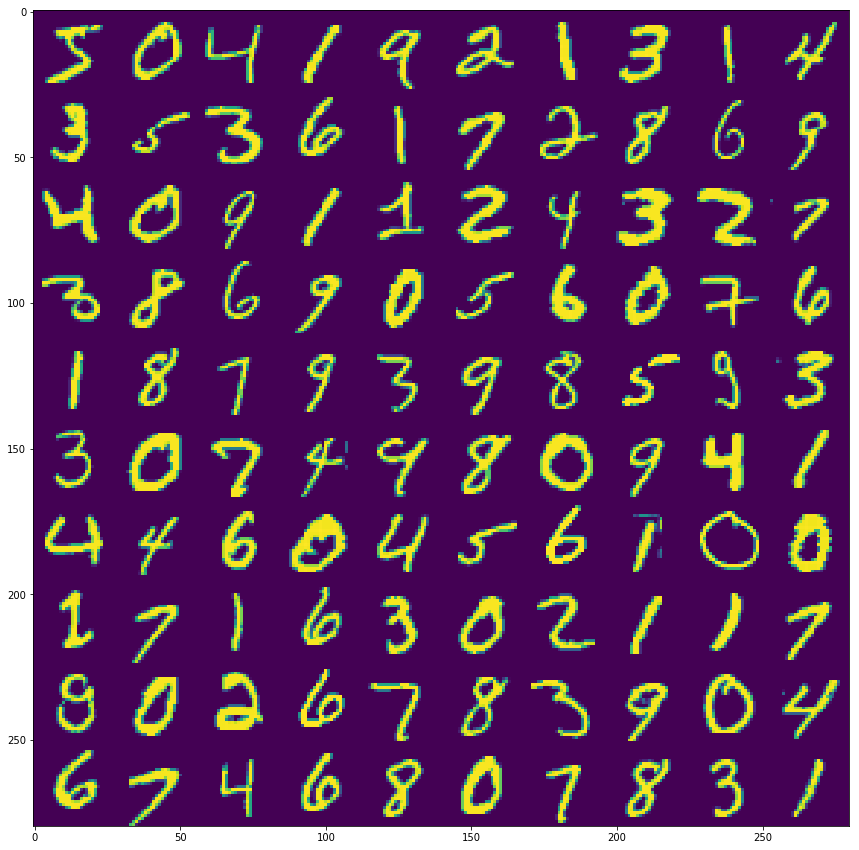

In [6]:
#input data
imshow(x_train[0:100])

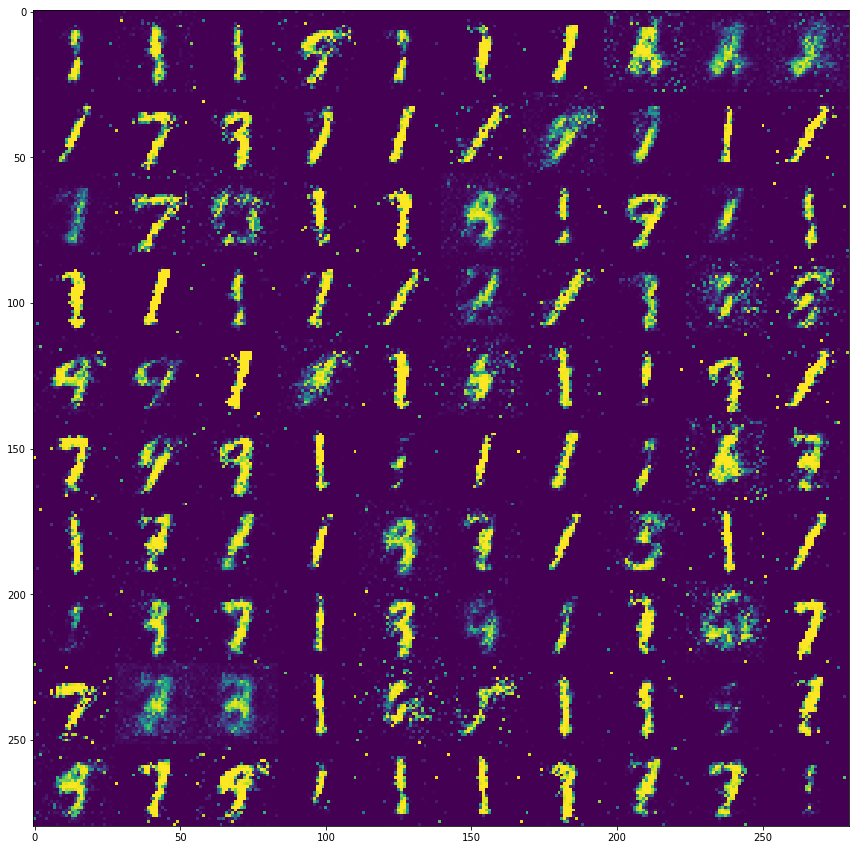

In [7]:
#generated data
imshow(sess.run(GEN_OUT, feed_dict={Z:np.random.uniform(-1, 1, size=(100, z_dim))}))

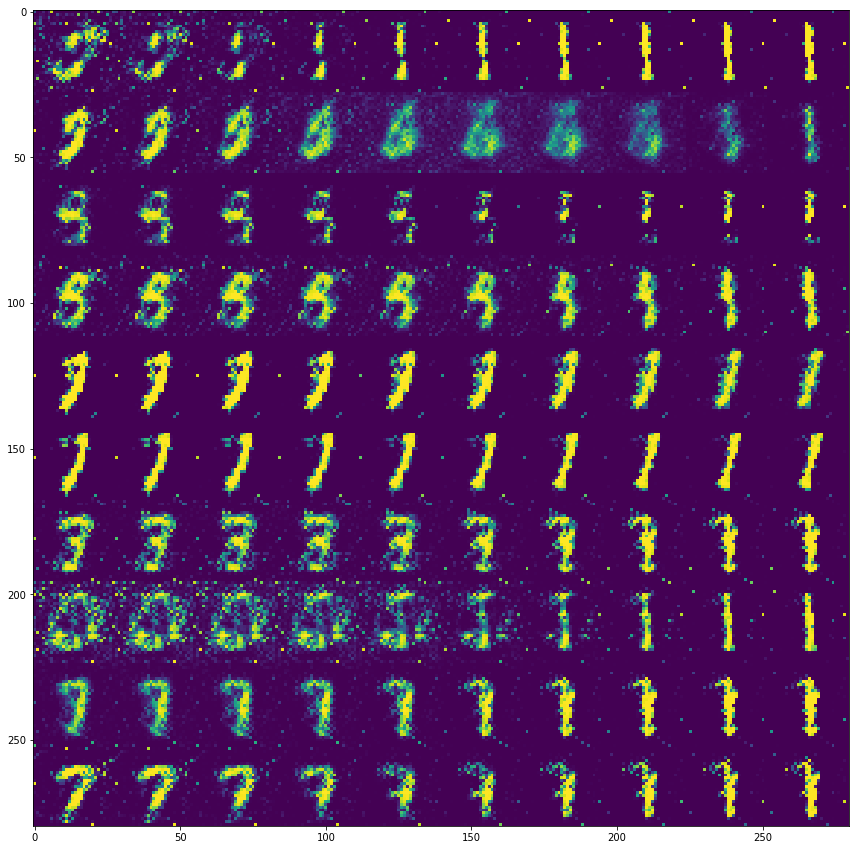

In [15]:
#feature investigation
z = np.random.uniform(-1, 1, size=(10, z_dim))
z = np.repeat(z, 10, axis=0)
z[:, 7] += np.repeat(np.arange(-1, 1, 0.2), 10).reshape(10, 10).T.flatten()
imshow(sess.run(GEN_OUT, feed_dict={Z:z}))